In [20]:
%load_ext autoreload
%autoreload 2
from torch import nn
import numpy as np
from utils import generate_random_numbers, plot_distribution
import torch

import matplotlib.pyplot as plt # type: ignore
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def custom_pdf(x):
    mean1, std1 = 2, 0.5
    mean2, std2 = 5, 0.5
    mean3, std3 = 8, 0.5

    gauss1 = np.exp(-0.5 * ((x - mean1) / std1) ** 2) / (std1 * np.sqrt(2 * np.pi))
    gauss2 = np.exp(-0.5 * ((x - mean2) / std2) ** 2) / (std2 * np.sqrt(2 * np.pi))
    gauss3 = np.exp(-0.5 * ((x - mean3) / std3) ** 2) / (std3 * np.sqrt(2 * np.pi))

    # sinusoidal_modulation = 0.5 * (1 + np.sin(2 * np.pi * x / 10))

    # return (gauss1 + gauss2 + gauss3) * sinusoidal_modulation
    return (gauss1 + gauss2 + gauss3) 

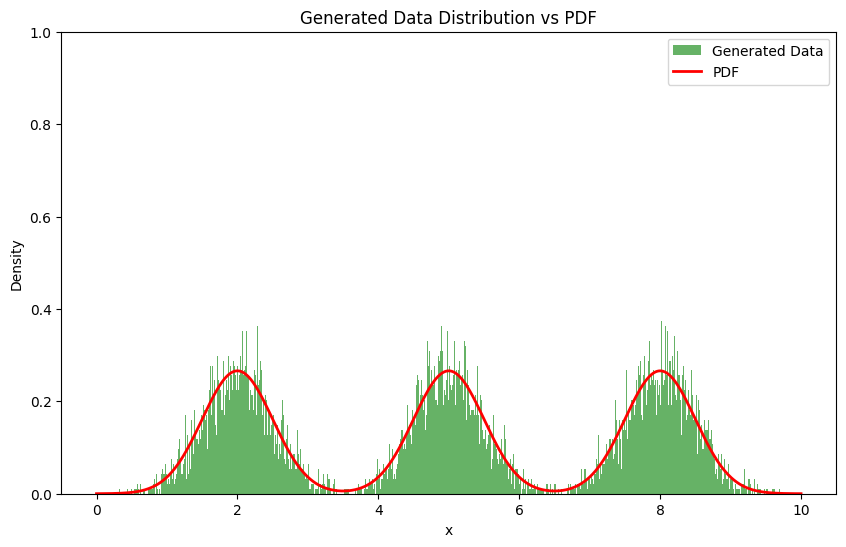

In [22]:
x_range = (0, 10)
num_samples = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"
samples = generate_random_numbers(custom_pdf, x_range, num_samples)
plot_distribution(samples, custom_pdf, x_range)
x0 = torch.from_numpy(samples).to(device)

In [23]:
class MLP(nn.Module):
    
    def __init__(self, N=40, data_dim=1, hidden_dim=64):
        super(MLP, self).__init__()
        
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)
        
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])
        
    def forward(self, x, t):
        
        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        
        return mu, std

In [9]:
class DiffusionModel():
    
    def __init__(self, T, model: nn.Module, dim=2):
        
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        
        self.T = T
        self.model = model
        self.dim = dim
        
    def forward_process(self, x0, t): 
        """
        :param t: Number of diffusion steps
        """
        assert t > 0, 't should be greater than 0'
        t = t -1 # Because we start indexing at 0
        
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        
        return mu + epsilon * std # data ~ N(mu, std)

    def reverse_process(self, xt, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert t <= self.T, f't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        
        return mu + epsilon * std # data ~ N(mu, std)
    
    
    def sample(self, batch_size):
        
        noise = torch.randn((batch_size, self.dim))
        x = noise
        
        samples = [x]
        for t in range(self.T, 0, -1):
            
            if not (t == 1):
                x = self.reverse_process(x, t)
            
            samples.append(x)
            
        return samples[::-1]
 
    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, self.dim]
        """
        
        t = torch.randint(2, 40+1, (1,))
        mu_q, sigma_q, xt = self.forward_process(x0, t)
                
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)
        
        KL = torch.log(sigma_p) - torch.log(sigma_q) + (
            sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K = - KL.mean() # Should be maximized
        loss = - K # Should be minimized
        
        return loss

In [24]:
class NumbersDataset(Dataset):
    def __init__(self, numbers):
        self.numbers = numbers

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, idx):
        number = self.numbers[idx]
        return torch.tensor(number, dtype=torch.float32)



In [26]:
batch_size = 64_000
epochs = 150_000
dataset = NumbersDataset(samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
mlp_model = MLP(hidden_dim=128).to(device)
model = DiffusionModel(40, mlp_model, device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)


training_loss = []
for epoch in tqdm(range(epochs)):
    for x0 in tqdm(dataloader):

        t = torch.randint(2, 40 + 1, (1,))
        loss = model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())
        
        if epoch % 5000 == 0:
            plt.plot(training_loss)
            plot_distribution(data[i].cpu(), custom_pdf, x_range)
            # plt.savefig(f'./figs/training_loss_epoch_{epoch}.png')
            # plt.close()
            
            # plot(diffusion_model, f'./figs/training_epoch_{epoch}.png', device)

tensor(4.9656, device='cuda:0', dtype=torch.float64)
tensor(2.4882, device='cuda:0', dtype=torch.float64)


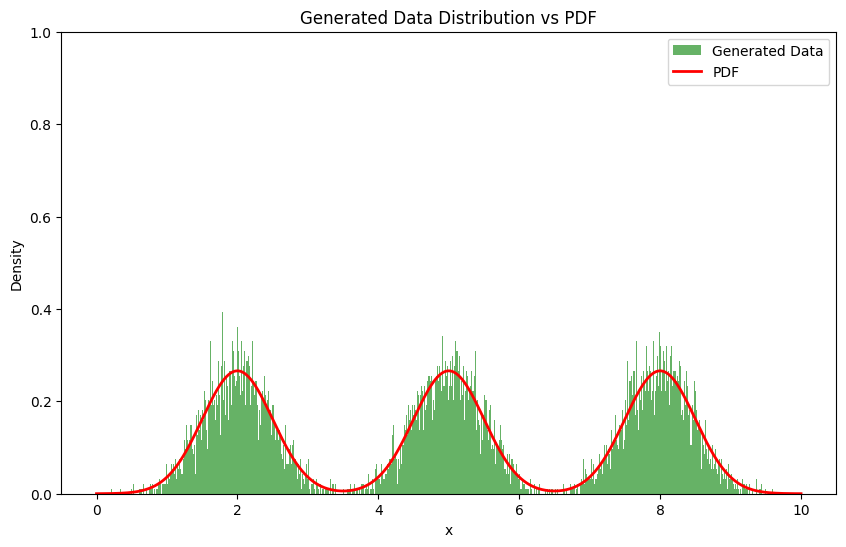

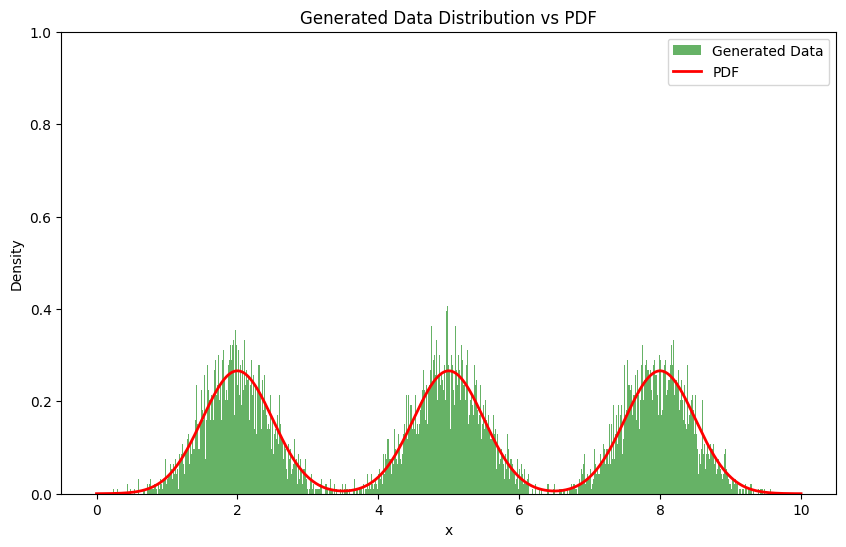

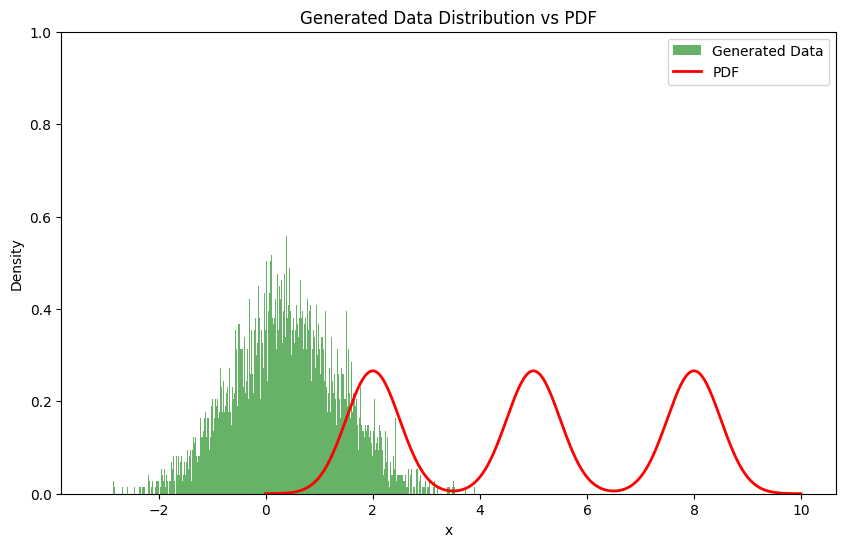

In [19]:
model = DiffusionModel(40)
xT = model.forward_process(x0, 20)
print(xT.mean(0))
print(xT.std(0))
# fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):
    plot_distribution(data[i].cpu(), custom_pdf, x_range)
   

In [16]:
data[0].cpu()

tensor([1.6025, 1.0163, 5.1281,  ..., 7.6443, 4.9373, 1.7846],
       dtype=torch.float64)